In [1]:
# Importing stuff
push!(LOAD_PATH, "/Users/robert/bio/BeNGS")
using NGSutilsFuncs
using Distributions
using HMMIDMethods
using HMMIDConfig
using Nucleotides
using States
using Observations
using NeedlemanWunsch
using PyPlot
using StatsBase

In [2]:
# Where is the HMMIDs directory relative to where you're running your julia notebook?
path_to_hmmids = "./"

"./"

# Making a simulated dataset

In [3]:
srand(1234)
sample_size = 1000

1000

In [4]:
sequences_in_fasta = []
for sequence in Nucleotides.FastaIterator("$(path_to_hmmids)data/P018_HQCS_short.fasta")
    push!(sequences_in_fasta, (sequence.label, replace(join(map(string, sequence.seq)), "-", "")))
end

In [52]:
number_of_reads = 100000
original_templates = sample_size
pcr_cycles = 35
double = log(2)
pcr_efficiency = 0.7
dist = Binomial(pcr_cycles, pcr_efficiency)
molecules = e.^(rand(dist, (original_templates)) * double)
template_count = zeros(Int64, original_templates)
for molecule in wsample(1:original_templates, molecules, number_of_reads)
    template_count[molecule] += 1
end;
#bar(1:original_templates, template_count);

#g = Geometric(1/51)
#template_count = rand(g, sample_size)

In [53]:
# Generating our dataset using our samples as seeds
primer_before_pid = "GATTACA"
pid_length = 8
primer_after_pid = "ACGTACGTGGAAGACTTA"
i = 1
true_sequences = Array{String,1}()
generated_sequences = Array{Tuple{String, String, Array{Float64}}}(sum(template_count))
generated_tag_counts = Dict()
tag_to_original_sequence = Dict()
generated_index = 1
@time for k in template_count
    sequence = sample(sequences_in_fasta)
    pid = join(rand(["A", "C", "G", "T"], pid_length))
    template = ("$(primer_before_pid)$(pid)$(primer_after_pid)$(sequence[2])")
    push!(true_sequences, template)
    generated = envPBseqSim(template, k, withQVs=true)
    for j in 1:length(generated)
        label = "PID_$(i)_$(pid)_$(j)_of_$(k)"
        generated_sequences[generated_index] = (label, generated[j][1], generated[j][2])
        generated_index += 1
        if generated_index % 50000 == 0
            try
                run(`say -r 600 Generated $(generated_index) sequences`)
            end
        end
    end
    generated_tag_counts[pid] = k
    tag_to_original_sequence[pid] = template
    i += 1
end
shuffle!(generated_sequences);

 74.580726 seconds (128.26 M allocations: 3.213 GB, 8.19% gc time)


In [54]:
println("$(length(Set(generated_tag_counts)) - length(generated_tag_counts)) duplicates")

0 duplicates


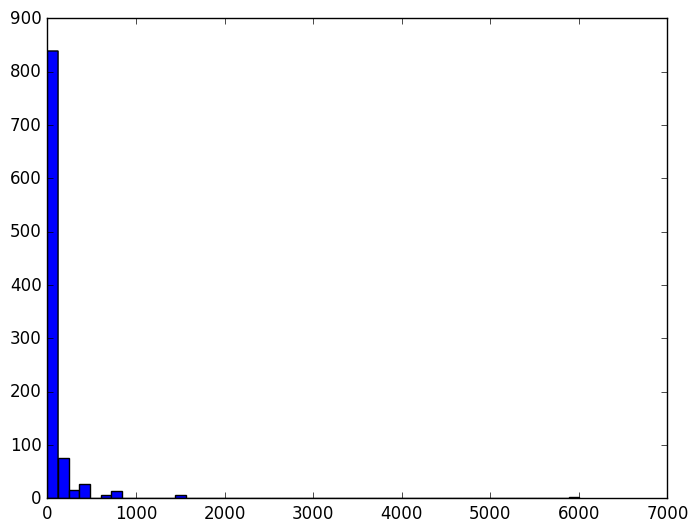

In [55]:
fig, ax = subplots()
ax[:hist](collect(values(generated_tag_counts)), 50);

# Running HMMIDS on Simulation Data

In [56]:
cfg = Configuration()
cfg.start_inclusive = 0
cfg.end_inclusive = length(primer_before_pid) + pid_length + length(primer_after_pid) + 5
cfg.try_reverse = false
push!(cfg.templates, Template("Reference", "$(primer_before_pid)$(repeat("n", pid_length))$(primer_after_pid)*"))

1-element Array{HMMIDConfig.Template,1}:
 HMMIDConfig.Template("Reference",States.AbstractState[States.StartingState(),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_A),States.BarcodeState(DNA_N),States.BarcodeState(DNA_N)  …  States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_A),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.RepeatingAnyState(DNA_N)])

In [57]:
tag_dict = Dict()

# This is the slow bit
@time for sequence in generated_sequences
    start_i = HMMIDMethods.py_index_to_julia(cfg.start_inclusive, length(sequence[2]), true)
    end_i = HMMIDMethods.py_index_to_julia(cfg.end_inclusive, length(sequence[2]), true)

    seq = map(DNASymbol, collect(sequence[2])[start_i:end_i])
    prob  = 1 - sequence[3][start_i:end_i]
    observations = map(Observations.Observation, seq, prob)
    
    score, tag, errors = NeedlemanWunsch.extract_tag(observations, cfg.templates[1].reference)
    
    tag = length(tag) > 0 ? join(map(string, tag), "") : "NO_TAG"
    tag = errors <= cfg.max_allowed_errors ? tag : "REJECTS"
    if !haskey(tag_dict, tag)
        tag_dict[tag] = []
    end
    push!(tag_dict[tag], (score, sequence))
end

138.336184 seconds (2.13 G allocations: 34.036 GB, 14.28% gc time)


In [58]:
real_tags = Set()
observed_tags = Set()
for observed_label in keys(tag_dict)
    for (score, sequence) in tag_dict[observed_label]
        real_label = split(sequence[1], "_")[3]
        push!(real_tags, real_label)
        push!(observed_tags, observed_label)
    end
end

In [59]:
tag_counts = Dict() 
tags = []
index = 1
for tag in keys(tag_dict)
    push!(tags, tag)
    tag_counts[tag] = length(tag_dict[tag])
end

# Resolving which tags are real

In [60]:
using Resolving
recurse = 1
pacbio_error_rate = 0.005
tag_to_index, index_to_tag = tag_index_mapping(tags)
@time probabilities_array = prob_observed_tags_given_reals(tag_to_index, Resolving.PacBioErrorModel(pacbio_error_rate), recurse)
indexed_counts = index_counts(tag_counts, tag_to_index);

 10.735850 seconds (72.00 M allocations: 3.215 GB, 26.97% gc time)


In [61]:
using CustomLDA
dirichlet_concentration = 0.5
most_likely_real_for_each_obs = CustomLDA.LDA(probabilities_array, indexed_counts, concentration=dirichlet_concentration);

In [62]:
minimum_bin_size = 1
likely_real = []
tag_to_prob = Dict()
for (observed_index, tuple) in enumerate(most_likely_real_for_each_obs)
    prob = tuple[2]
    if tag_counts[index_to_tag[observed_index]] <= minimum_bin_size
        prob = 0
    end
    if observed_index != tuple[1]
        prob = 0
    end
    tag_to_prob[index_to_tag[observed_index]] = prob
    push!(likely_real, (prob, index_to_tag[observed_index]))
end
sort!(likely_real)

2657-element Array{Any,1}:
 (0,"AAAAAATTT")      
 (0,"AAAAACG")        
 (0,"AAAAATTTT")      
 (0,"AAAACACA")       
 (0,"AAAACTACA")      
 (0,"AAAACTG")        
 (0,"AAAATACA")       
 (0,"AAACAACA")       
 (0,"AAACACATC")      
 (0,"AAACACC")        
 (0,"AAACCAC")        
 (0,"AAACCCCAT")      
 (0,"AAACCGA")        
 ⋮                    
 (0.999998,"TCCTGCGA")
 (0.999998,"TCGGTAAT")
 (0.999998,"CTTGTGTA")
 (0.999998,"GTCATCGG")
 (0.999998,"ATTTAAAG")
 (0.999999,"CATAGGGA")
 (0.999999,"CGCTTGGT")
 (0.999999,"CATCCGTC")
 (0.999999,"TGAGCAAG")
 (0.999999,"CCTTTATC")
 (1.0,"CTATGACG")     
 (1.0,"CACTGGCA")     

In [63]:
count_tag = []
for tag in keys(tag_counts)
    push!(count_tag, (tag_counts[tag], tag))
end
sort!(count_tag)

2657-element Array{Any,1}:
 (1,"AAAAACG")    
 (1,"AAAAATTTT")  
 (1,"AAAACACA")   
 (1,"AAAACTG")    
 (1,"AAACACATC")  
 (1,"AAACACC")    
 (1,"AAACCAC")    
 (1,"AAACCCCAT")  
 (1,"AAACCGA")    
 (1,"AAACGAAAC")  
 (1,"AAACGAAT")   
 (1,"AAACGGGAGA") 
 (1,"AAACTAAA")   
 ⋮                
 (1419,"AATCGCTA")
 (1426,"ACCGTTTA")
 (1427,"TAGGTAGA")
 (1437,"GATGCGTT")
 (1449,"GTGGCACT")
 (1500,"TGCTATCT")
 (1521,"GTCTGATT")
 (2806,"TCACAATA")
 (2809,"TTTTACAT")
 (2916,"GGGCTCCC")
 (5768,"AACGGAGA")
 (5808,"AAACTACA")

In [64]:
function false_pos_neg_graph(pairs, real_tags)
    false_positive_count = 0
    true_positive_count = 0
    for (value, tag) in pairs
        if (tag in real_tags)
            true_positive_count += 1
        else
            false_positive_count += 1
        end
    end
    x_values = [false_positive_count]
    y_values = [true_positive_count]
    for (value, tag) in pairs
        if tag in real_tags
            true_positive_count -= 1
        else
            false_positive_count -= 1
        end
        push!(x_values, false_positive_count)
        push!(y_values, true_positive_count)
    end
    return x_values, y_values
end

false_pos_neg_graph (generic function with 1 method)

In [65]:
function filter_out_same_values(sorted_values, dependant_variable)
    out = [dependant_variable[1]]
    last_value = 0
    for i in 1:length(sorted_values)
        if sorted_values[i] > last_value
            push!(out, dependant_variable[i+1])
            last_value = sorted_values[i]
        end
    end
    return out
end

filter_out_same_values (generic function with 1 method)

In [66]:
x_us, y_us = false_pos_neg_graph(likely_real, real_tags) 
x_us = filter_out_same_values([x[1] for x in likely_real], x_us)
y_us = filter_out_same_values([x[1] for x in likely_real], y_us)
short_likely_real = vcat([0.], [x[1] for x in likely_real])
short_likely_real = filter_out_same_values([x[1] for x in likely_real], short_likely_real)

x_ron, y_ron = false_pos_neg_graph(count_tag, real_tags)
x_ron = filter_out_same_values([x[1] for x in count_tag], x_ron)
y_ron = filter_out_same_values([x[1] for x in count_tag], y_ron)
short_count_tag = vcat([0], [x[1] for x in count_tag]) 
short_count_tag = filter_out_same_values([x[1] for x in count_tag], short_count_tag);

In [87]:
type GraphVariables 
    sample_size
    number_of_reads
    recurse
    pacbio_error_rate
    dirichlet_concentration
    pcr_cycles
    pcr_efficiency
    minimum_bin_size
end
GraphVariables() = GraphVariables(1000,100000,1,0.005,0.5,45,0.7,1)
function GraphVariables(symbols::Array{Symbol}, values::Array{Any})
    gv = GraphVariables()
    for symbol, value in zip(symbols, values)
        setfield!(gv, symbol, value)
    end
    return gv
end

LoadError: LoadError: syntax: invalid iteration specification
while loading In[87], in expression starting on line 14

In [67]:
# Read from file
filename = "BensTempOutput.csv"
plots = []
if isfile(filename)
    file = open(filename)
    variables = map(Symbol, split(strip(readline(file)), ","))
    info(variables)
    number_of_plots = parse(strip(readline(file)))
    info("Reading $(number_of_plots) existing plots from file")
    for i in 1:number_of_plots
        parameters = map(parse, split(strip(readline(file)),","))
        our_threshold = map(parse, split(strip(readline(file)),","))
        our_x = map(parse, split(strip(readline(file)),","))
        our_y = map(parse, split(strip(readline(file)),","))
        rons_threshold = map(parse, split(strip(readline(file)),","))
        rons_x = map(parse, split(strip(readline(file)),","))
        rons_y = map(parse, split(strip(readline(file)),","))
        push!(plots, (parameters, our_threshold, our_x, our_y, rons_threshold, rons_x, rons_y))
    end
end

INFO: Symbol[:sample_size,:number_of_reads,:recurse,:pacbio_error_rate,:dirichlet_concentration,:pcr_cycles,:pcr_efficiency,:minimum_bin_size]
INFO: Reading 3 existing plots from file


In [68]:
push!(plots, (map(eval, variables), short_likely_real, x_us, y_us, short_count_tag, x_ron, y_ron))

4-element Array{Any,1}:
 (Real[1000,100000,1,0.005,0.5,45,0.7,1],[0.0,0.499761,0.514866,0.515676,0.515714,0.516331,0.519383,0.529552,0.530804,0.531473  …  0.999999,0.999999,0.999999,0.999999,1.0,1.0,1.0,1.0,1.0,1.0],[1628,296,295,294,293,292,291,290,289,288  …  0,0,0,0,0,0,0,0,0,0],[878,802,802,802,802,802,802,802,802,802  …  15,14,13,11,9,6,4,3,2,1],[0,1,2,3,4,5,6,7,8,9  …  1805,1822,1832,1838,1845,3561,3590,3667,7240,7250],[1628,1627,424,195,108,80,55,35,27,26  …  0,0,0,0,0,0,0,0,0,0],[878,878,802,747,708,674,640,612,582,561  …  9,8,7,6,5,4,3,2,1,0])                           
 (Real[1000,100000,1,0.025,0.5,45,0.7,1],[0.0,0.372689,0.497593,0.506031,0.509927,0.514882,0.547755,0.553626,0.554887,0.565439  …  0.999986,0.999988,0.999988,0.999988,0.999988,0.999993,0.999993,0.999997,0.999998,0.999998],[1628,122,121,120,119,118,117,116,115,114  …  0,0,0,0,0,0,0,0,0,0],[878,801,801,801,801,801,801,801,801,801  …  10,9,8,6,5,4,3,2,1,0],[0,1,2,3,4,5,6,7,8,9  …  1805,1822,1832,1838,1845,3561,359

In [69]:
length(plots[3][4])

1198

In [70]:
# Write to file
parameters = 
file = open(filename, "w")
write(file, "$(join(variables, ","))\n")
write(file, "$(length(plots))\n")
for plot in plots
    write(file, "$(join(plot[1], ","))\n") # The values of the parameters for the plot
    write(file, "$(join(plot[2], ","))\n") # Our threshold values
    write(file, "$(join(plot[3], ","))\n") # Our x values
    write(file, "$(join(plot[4], ","))\n") # Our y values
    write(file, "$(join(plot[5], ","))\n") # Ron's threshold values
    write(file, "$(join(plot[6], ","))\n") # Ron's x values
    write(file, "$(join(plot[7], ","))\n") # Ron's y values
end
close(file)

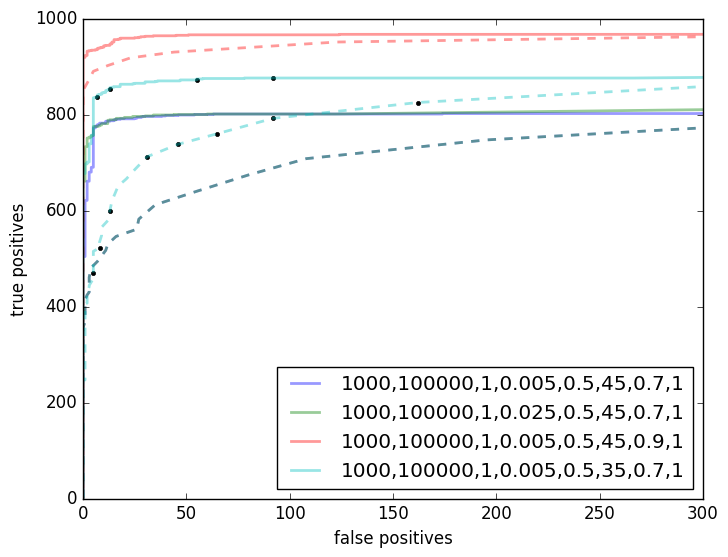

0.9 - 92 false positive, 876 true positive (out of 990)
0.95 - 55 false positive, 872 true positive (out of 990)
0.99 - 13 false positive, 854 true positive (out of 990)
0.995 - 7 false positive, 837 true positive (out of 990)


In [71]:
fig, ax = subplots()

# Printing points for the different special thresholds
# Ben's threshold points
threshold = [.9, .95, .99, .995, 100]
threshold_i = 1
for i in 1:length(short_likely_real)
    if short_likely_real[i][1] > threshold[threshold_i]
        ax[:plot](x_us[i], y_us[i], ".", color="black", )
        println("$(threshold[threshold_i]) - $(x_us[i]) false positive, $(y_us[i]) true positive (out of $(length(generated_tag_counts)))")
        threshold_i += 1
    end
end
# Ron's 
threshold = [1, 2, 3, 4, 5, 10, 15, 20, 10000000]
threshold_i = 1
for i in 1:length(short_count_tag)
    if short_count_tag[i][1] > threshold[threshold_i]
        ax[:plot](x_ron[i+1], y_ron[i+1], ".", color="black")
        threshold_i += 1
    end
end

# Plotting the plots from the save file, as well as our new plots
for plot in plots
    parms = ax[:plot](plot[3], plot[4], linewidth=2, label="$(join(plot[1],","))", alpha=0.4)
    chosen_color = parms[1][:get_color]()
    ax[:plot](plot[6], plot[7], linestyle="--", linewidth=2, color=chosen_color, alpha=0.4)
end

ax[:legend](loc=4)
xlim([0,300])
#ylim([1500,2000])
#ylim([700,900])
xlabel("false positives")
ylabel("true positives");


In [72]:
threshold = 0.95
included = Set()
excluded = Set()
for (prob, tag) in likely_real
    if prob >= threshold
        push!(included, tag)
    else
        push!(excluded, tag)
    end
end

In [73]:
# Of the initial number of tags, how many are recovered?
recovered_tags = 0
for generated_tag in keys(generated_tag_counts)
    if generated_tag in included
        recovered_tags += 1
    end
end
println("Of the $(length(generated_tag_counts)) original tags, $(recovered_tags) were recovered")

Of the 990 original tags, 873 were recovered


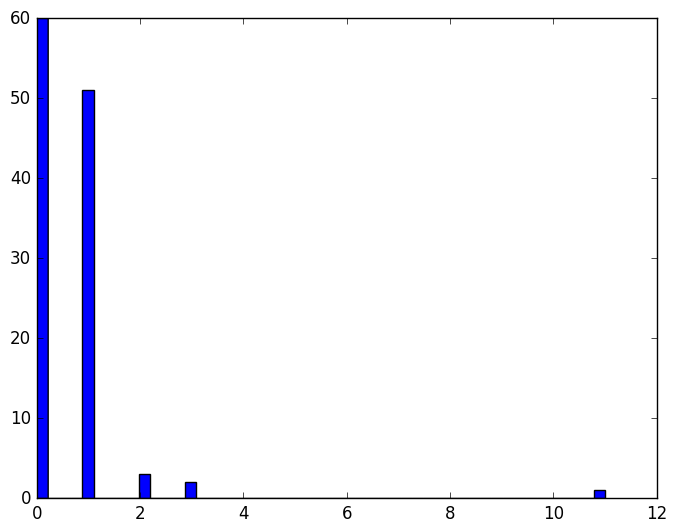

CTCTGATT - 11 generated copies - 10 seen copies - 0.94928896 probability of being real
	CTCTGATT - 10 seen copies - 0.96069306 chance of indel
	CTCTGAT - 1 seen copies - 0.0038780828 chance of indel
	CTCGATT - 1 seen copies - 0.0019410417 chance of indel
	TCTGATT - 1 seen copies - 0.0019397084 chance of indel
	CTATGATT - 4 seen copies - 0.0003243422 chance of indel
	GTCTGATT - 1521 seen copies - 0.00032434214 chance of indel
	ACTCTGAT - 189 seen copies - 4.0f-6 chance of indel
	GTCTGAT - 7 seen copies - 2.6666667f-6 chance of indel
	GCTGATT - 3 seen copies - 2.6666667f-6 chance of indel
	CTGTGAT - 2 seen copies - 2.6666667f-6 chance of indel
	CTCTACTT - 16 seen copies - 2.2222223f-6 chance of indel
	ACTCGATT - 19 seen copies - 2.0f-6 chance of indel
	GTCTATT - 3 seen copies - 1.3333333f-6 chance of indel
	GTCGATT - 2 seen copies - 1.3333333f-6 chance of indel
	GTTGATT - 2 seen copies - 1.3333333f-6 chance of indel
	CTCTACT - 1 seen copies - 1.3333333f-6 chance of indel
	GTCTGTT - 4 see

In [74]:
# Of the unrecovered tags, how many copies were generated
unrecovered_copy_count = []
but = "None"
buts = 0
for generated_tag in keys(generated_tag_counts)
    if !(generated_tag in included)
        push!(unrecovered_copy_count, generated_tag_counts[generated_tag])
        if generated_tag_counts[generated_tag] > buts
            buts = generated_tag_counts[generated_tag]
            but = generated_tag
        end
    end
end
fig, ax = subplots()
ax[:hist](unrecovered_copy_count, 50);
println("$(but) - $(buts) generated copies - $(tag_counts[but]) seen copies - $(tag_to_prob[but]) probability of being real")
for (index, prob) in sort!(probabilities_array[tag_to_index[but]], by=x->-x[2])
    println("\t$(index_to_tag[index]) - $(tag_counts[index_to_tag[index]]) seen copies - $(prob) chance of indel")
end


In [75]:
# Of the recovered tags, how many are valid?
valid_tags = 0
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        valid_tags += 1
    end
end
println("Of the $(length(included)) recovered tags, $(valid_tags) were valid, with a false positive rate of $(round((length(included)-valid_tags)/length(included)*100,4))%")

Of the 928 recovered tags, 873 were valid, with a false positive rate of 5.9267%


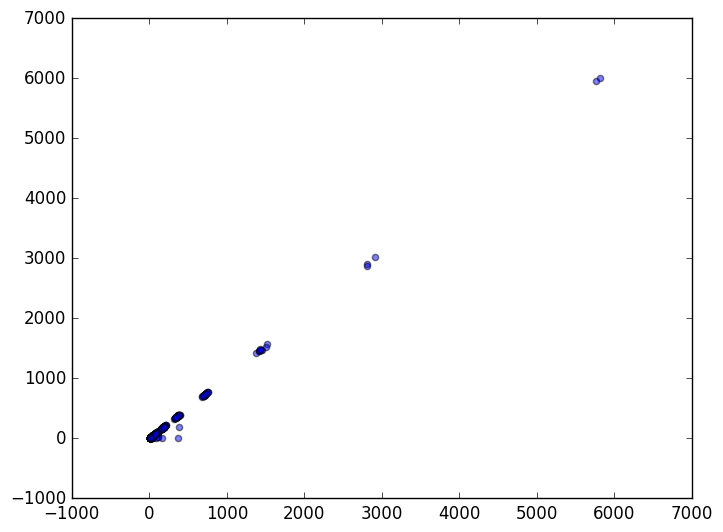

In [76]:
# Of the validly recovered tags, how many of the original sequences are recovered
recovered = []
out_of = []
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2][1], "_")[3]
            if real_label == recovered_tag
                matching += 1
            end
        end
        push!(recovered, matching)
        push!(out_of, generated_tag_counts[recovered_tag])
    end
end
scatter(recovered, out_of, alpha=0.5);

In [77]:
# Of the validly recovered tags, how many mismatched sequences are included
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        non_matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2][1], "_")[3]
            if real_label != recovered_tag
                non_matching += 1
            end
        end
        if non_matching > 0
            println("$(non_matching) out of $(length(tag_dict[recovered_tag])) mismatched tags for $(recovered_tag)")
        end
    end
end

1 out of 87 mismatched tags for CCCAGGAC
1 out of 10 mismatched tags for AGGGGGCG
1 out of 168 mismatched tags for CATGAAAC
1 out of 10 mismatched tags for AGTCGGCC
1 out of 14 mismatched tags for CCCATTGG
1 out of 3 mismatched tags for TCCCGCTA
1 out of 58 mismatched tags for TTTTCCAT


# Getting consensuses

edit_distances = []
number_of_copies = []
consensuses = []
for recovered_tag in included
    if !(recovered_tag in keys(tag_to_original_sequence))
        println("$(recovered_tag) not actually an original tag")
        continue
    end
    sequences = map(x -> x[2][2], tag_dict[recovered_tag])
    consensus_seq = consensusSeq(sequences)
    push!(consensuses, consensus_seq)
    original = tag_to_original_sequence[recovered_tag]
    distance = kmerSeededEditDist(consensus_seq, original)
    push!(edit_distances, distance)
    push!(number_of_copies, generated_tag_counts[recovered_tag])
    #println("$(recovered_tag) recovered with $((length(original) - distance) / length(original) * 100)% accuracy")
end

sum(edit_distances)

scatter(log(Array{Float64}(number_of_copies))+randn(length(edit_distances))*0.1, edit_distances+randn(length(edit_distances))*0.1, alpha = 0.1);